In [2]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

In [182]:
# armchair edges

t=1.0
t_sc=0.5

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])


def make_system(Delta=0.2,
                W=200, L=200, Lsc=20, t_j=0.1, mu=0.6, mu_sc=2, phi=0):

            
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < W) and (0 <= y < L)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         print([xi,yi,xj,yj])
#         # modulated hopping in x direction
#         if yi<1 and yj<1:
#             H1=-t*tau_z
#         else:
#         phi0= phi* ((yi+yj)/2 >= 0)
        H1=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        return H1

    def onsite(site, mu):
        return  - mu*tau_z

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3), 0), (0, 1)],
                                [(0, 0), (1/sqrt(3), 0), (3/sqrt(3)/2, 0.5),(5/sqrt(3)/2, 0.5)],norbs=2)
    subA1, subB1,subA2, subB2 = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (0,0))] = onsite
    syst[lat.neighbors()] = hopping_ab

    
    def hopping_jn(site_i, site_j, t_j, phi):
        return -t_j*tau_z
#         xi, yi = site_i.pos
#         xj, yj = site_j.pos
# #         print([xi,yi,xj,yj])
# #         # modulated hopping in x direction
# #         if yi<1 and yj<1:
# #             H1=-t*tau_z
# #         else:
#         H1=tinyarray.array([[-t_j*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
#                             [0,t_j*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
#         return H1

#     def onsite_jn(site, mu, V_j):
#         return  (V_j- mu)* tau_z 

    # sc part
    def onsite_sc(site, mu_sc, Delta):
        return  (- mu_sc + 4 * t_sc)* tau_z + Delta *tau_x

    def hopping_sc(site1, site2):
        return -t_sc* tau_z
    
    a0=3/(4*sqrt(3))
    b0=0.5
    primitive_vectors = [(a0, 0), (0, b0)]
    lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(a0/6,0),norbs=2)

    Wsq=int(W/a0)
    Lsq=int(Lsc/b0)-1
    syst[(lat_sc(x,y) for x in range(Wsq) for y in range(-Lsq+1,0))] = onsite_sc
    syst[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    syst[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    syst[((lat_sc(4*i,-1), subA1(i,0)) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+1,-1), subB1(i,0)) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+2,-1), subA2(i,0)) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+3,-1), subB2(i,0)) for i in range(int(Wsq/4)))] = hopping_jn

    sym_right = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    right_lead = kwant.Builder(sym_right, particle_hole=tau_y)
    right_lead[lat.shape(qh_slab, (0,0))] = onsite
    right_lead[lat.neighbors()] = hopping_ab
    
    right_lead[(lat_sc(x,y) for x in range(4) for y in range(-Lsq+1,0))] = onsite_sc
    right_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    right_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    
    right_lead[(lat_sc(0,-1), subA1(0,0))] = hopping_jn
    right_lead[(lat_sc(1,-1), subB1(0,0))] = hopping_jn
    right_lead[(lat_sc(2,-1), subA2(0,0))] = hopping_jn
    right_lead[(lat_sc(3,-1), subB2(0,0))] = hopping_jn

    
    c1=-tau_z
    sym_left = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    l1_lead = kwant.Builder(sym_left, conservation_law=c1, particle_hole=tau_y)
    l1_lead[lat.shape(qh_slab, (0,0))] = onsite
    l1_lead[lat.neighbors()]= hopping_ab
    
    syst.attach_lead(l1_lead.reversed())
    syst.attach_lead(right_lead)
    
    return syst

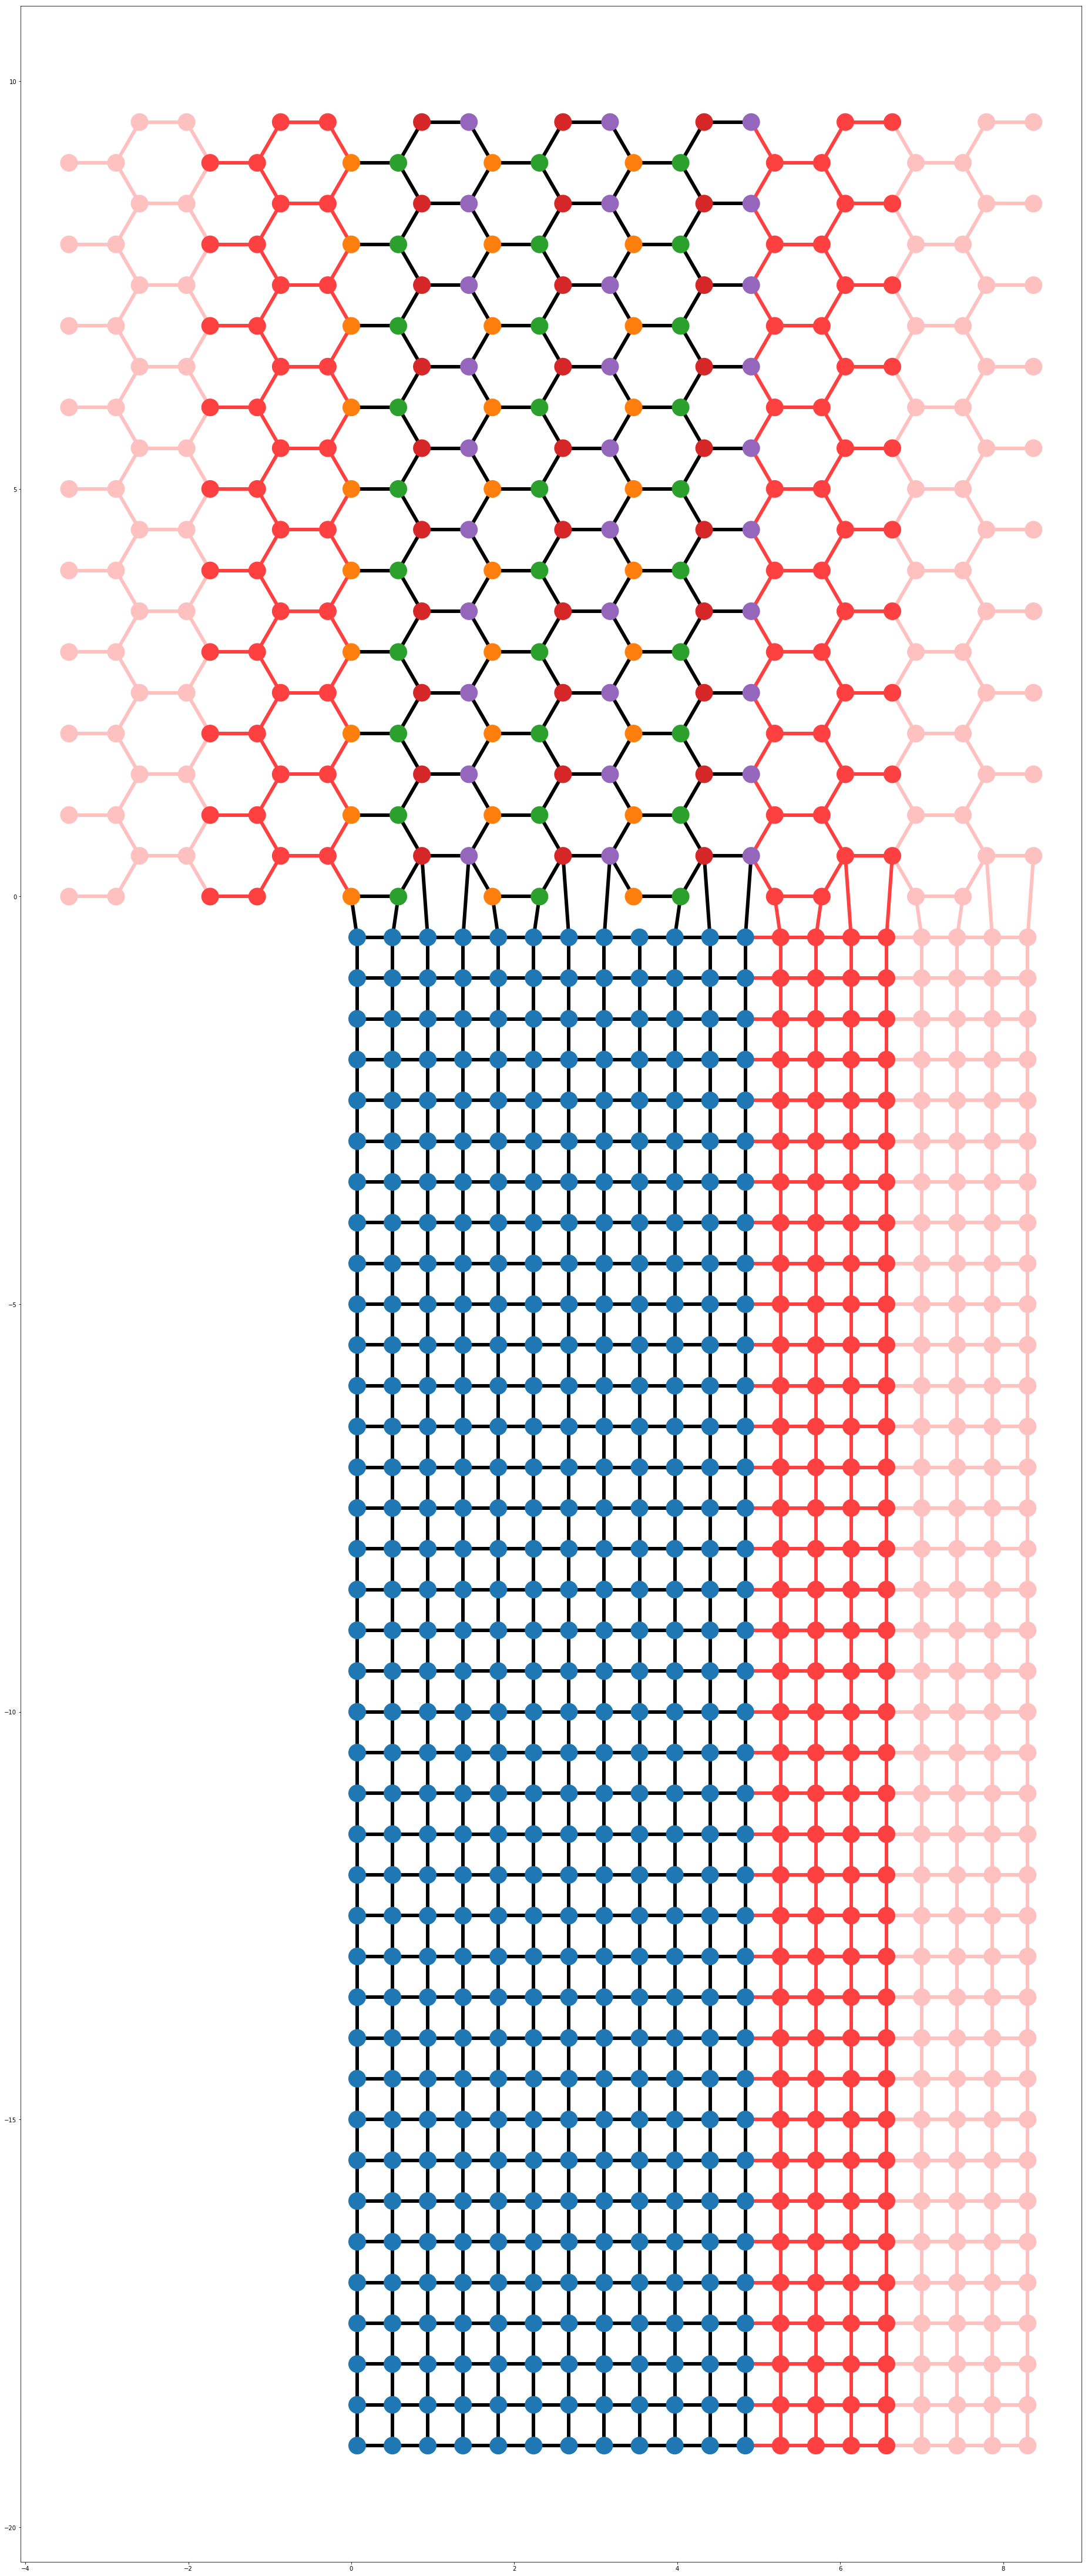

In [186]:
# Wsc must be multiples of eight
W=4
L=10
Lsc=20
syst = make_system(W=W, L=L, Lsc=Lsc)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(40,80),num_lead_cells=2)
# kwant.plot(syst,num_lead_cells=2)
# Finalize the system.
syst = syst.finalized()

(2, 11288)


/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: The plotted data contains 1.74% of values overflowing upper limit 0.199104 
  from ipykernel import kernelapp as app


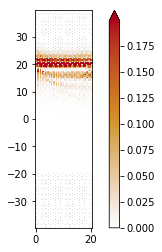

/tmp/yes/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: The plotted data contains 1.68% of values overflowing upper limit 0.144457 
  app.launch_new_instance()


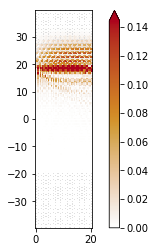

In [23]:
mu=0.145
mu_sc= mu+t
Delta=0.03
t_j=1.0
phi=0.0095

energy=-0.*Delta
params=dict(t_j=t_j, Delta=Delta ,mu=mu ,mu_sc=mu_sc,phi=phi)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,::2])**2, axis=0)-np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
print(scattering_wf.shape)
ind=0
kwant.plotter.map(syst, abs(scattering_wf[ind,::2])**2)#,vmax=0.7);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::2])**2);#,ax=ax2);

In [380]:
def compute_conductance(syst, energies, params):
    # Compute conductance
    Pe = np.zeros((2,len(energies)))
    for i_e in range(len(energies)):
        print(i_e, end='\r')
        energy=energies[i_e]
        smatrix = kwant.smatrix(syst, energy=energy,params=params)
        for i in range(2):
            Pe[i,i_e]=smatrix.transmission((1, i), (0, 0))
    return Pe


# Compute and plot the conductance
E_list=np.arange(-10, 11)*0.1*Delta
t_timer=time.time()
# Compute and plot the conductance
# Pe, Ph, wf_arr= compute_conductance(syst, energies=[E for E in E_list], params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt) )
Pe = compute_conductance(syst, energies=[E for E in E_list], params=params )
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

Finished, elapsed time = 15 sec


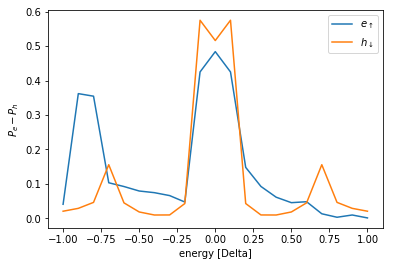

In [381]:
plt.figure()
plt.plot(E_list/Delta, Pe.T)
plt.legend((r'$e_\uparrow$', r'$h_\downarrow$'))
plt.xlabel("energy [Delta]")
plt.ylabel(r"$P_e - P_h$")
# P_diff=Pe[0,:]-Pe[1,:]
# plt.plot(E_list/Delta, P_diff.T)
plt.show()

In [187]:
mu=0.145
mu_sc= mu+t
Delta=0.03
t_j=1.0
phi=0.0095

# momenta = [(-pi + 0.01 * pi * i)/5 for i in range(201)]
momenta=np.linspace(-1,1,200)*pi
# def plot_wf(phi=0.03):
# params=dict(t_j=t_j, gn=gn, lam=lam, gs=gs, Delta=Delta, mu=mu ,mu_sc=mu_sc,phi=phi,momenta=momenta)
# fig = plt.figure()  # create a figure object
# ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
# ax1.set_ylim(-0.06,0.06)
# #     ax1.set_xlim(-3,-1)
# plt.show()
    
# interact(plot_wf, phi=(0, 0.1, 0.002));
# plot_wf(phi=0.0095*4.5)

params=dict(t_j=t_j, Delta=Delta, mu=mu, mu_sc=mu_sc, phi=phi)

bands = kwant.physics.Bands(syst.leads[1], params=params)
energies = [bands(k) for k in momenta]


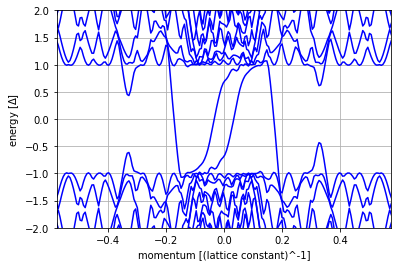

In [188]:
plt.figure()
plt.plot(np.array(momenta)/pi/sqrt(3), np.array(energies)/Delta,'b')
# plt.plot((momenta), (energies))
plt.ylim(-2,2)
plt.xlim(-1/sqrt(3),1/sqrt(3))
plt.xlabel("momentum [(lattice constant)^-1]")
plt.ylabel(r"energy [$\Delta$]")
plt.grid()
plt.show()